<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import holidays
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [2]:
!pip install holidays --upgrade

     |████████████████████████████████| 172 kB 12.0 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [3]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv


--2022-04-15 21:38:10--  https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3274443 (3.1M) [text/plain]
Saving to: ‘DAYTON_hourly.csv’

DAYTON_hourly.csv   100%[===================>]   3.12M  --.-KB/s    in 0.03s   

2022-04-15 21:38:11 (102 MB/s) - ‘DAYTON_hourly.csv’ saved [3274443/3274443]



In [4]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

#data.resample('3H').sum()
#data = data.resample('6H').sum()
data = data.resample('12H').sum()
#data.resample('1D').sum()
#data.resample('1W').sum()
#data.resample('1Y').sum()
#data.groupby([data.index.year == 2015,data.index.month <3 ])['DAYTON_MW'].sum()

In [5]:
data.shape

(10109, 1)

In [ ]:
data.tail(5)

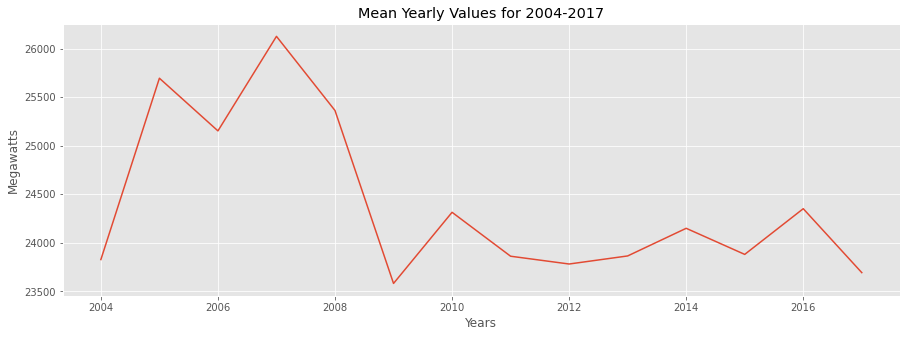

In [7]:
# YEARLY CONSUMPTIONS

mean_yearly_consumptions = []
years = []

for i in range(2004, 2018):
  mean_yearly_consumptions.append(data[data.index.year == i].mean())
  years.append(i)

plt.figure(figsize = (15, 5))
plt.plot(years, mean_yearly_consumptions)

plt.title("Mean Yearly Values for 2004-2017")
plt.xlabel("Years")
plt.ylabel("Megawatts")

plt.show()

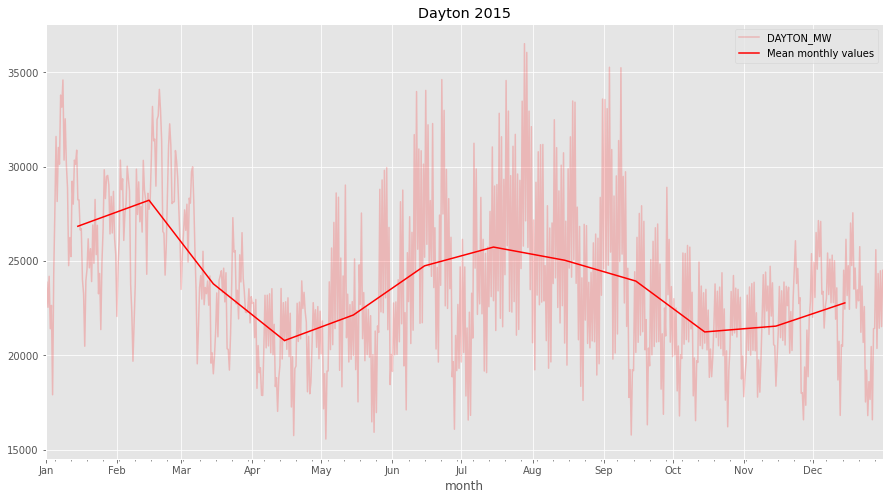

In [8]:
year_2015 = data[data.index.year == 2015]

month_mean_values = []
months = []
xticks = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in (range(1,13)):
    month_mean_values.append(year_2015[(year_2015.index.month == i)]['DAYTON_MW'].mean())
    months.append(datetime.datetime(2015, i, 15))
    xticks.append(datetime.datetime(2015, i, 1)) 

month = pd.DataFrame({'Mean monthly values': month_mean_values, 'month':months })
month = month.set_index('month')

base=year_2015.plot(color='red',alpha=0.20, figsize = (15, 8), title = 'Dayton 2015')
month.plot(color='red', alpha=1.0, ax=base)
plt.xticks(xticks, month_names)

plt.show()

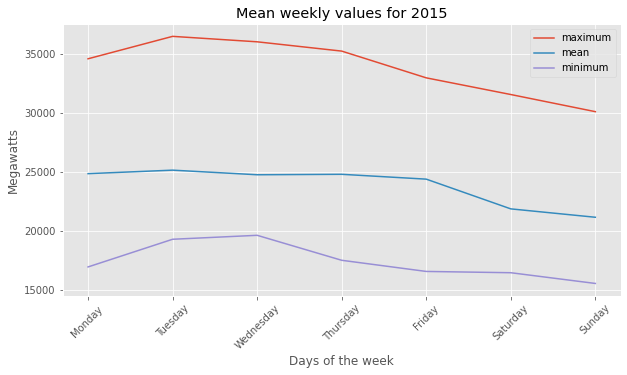

In [9]:
# VALUES BY WEEKDAY

mean_weekday = []
max_weekday = []
min_weekday = []
weekdays = ['Monday ', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(0, 7):
  mean_weekday.append(data[(data.index.year == 2015) & (data.index.weekday == i)].mean())
  max_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].max())
  min_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].min())

plt.figure(figsize = (10, 5))
plt.plot(weekdays, max_weekday, weekdays, mean_weekday, weekdays, min_weekday)

plt.title('Mean weekly values for 2015')
plt.xlabel('Days of the week')
plt.ylabel('Megawatts')
plt.xticks(weekdays, rotation = 45)
plt.legend(['maximum', 'mean', 'minimum'])

plt.show()

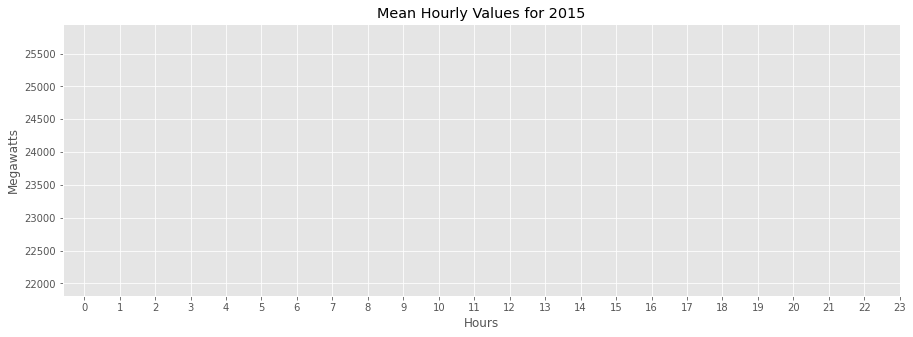

In [11]:
#           MEAN HOURLY VALUES

mean_hourly_values = []
hours = [x for x in range(0, 24)]

for i in range(0, 24):
  mean_hourly_values.append(data[(data.index.year == 2015) & (data.index.hour == i)].mean())

plt.figure(figsize = (15, 5))
plt.plot(hours, mean_hourly_values)

plt.title("Mean Hourly Values for 2015")
plt.xlabel("Hours")
plt.ylabel("Megawatts")
plt.xticks(hours)

plt.show()

Preprocessing

- Normalize the dataset

In [72]:
data = data[data.index.year >= 2008]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

- Splitting the training and test sets

In [73]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

4813 3850 963


In [74]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [75]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
# https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Hyperparameters

In [76]:
n_epochs = 100                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0002   

n_input = 1                       # Scalar input.
n_neurons = 128                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

Create model

In [77]:
my_model = Sequential()
my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

# Define the optimizer and compile.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
my_model.summary()

Train model

In [78]:
my_summary = my_model.fit(trainX, trainY, epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [22]:
#my_model.save('LSTM_model.h5')
#my_model = load_model('LSTM_model.h5')

In [79]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

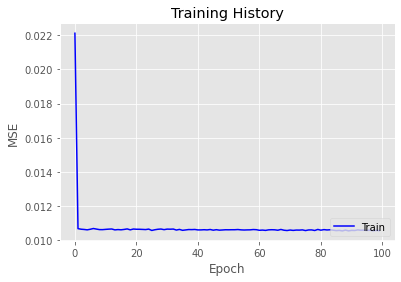

In [80]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

Predict

In [105]:
# make predictions
trainPredict = my_model.predict(trainX)
testPredict = my_model.predict(testX)

In [106]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))

In [107]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8814317585438283637272591867288515380562162774429701627262795776.00 RMSE
Test Score: 232438764364786839507945799524805051961278193123728044326912.00 RMSE


Evaluate predictions

In [108]:
trainPred = pd.DataFrame({'Prediction' : trainPredict.reshape(-1)}, index = data.iloc[:len(trainPredict)].index)
testPred = pd.DataFrame({'Prediction' : testPredict.reshape(-1)}, index = data.iloc[-len(test)+1:].index)

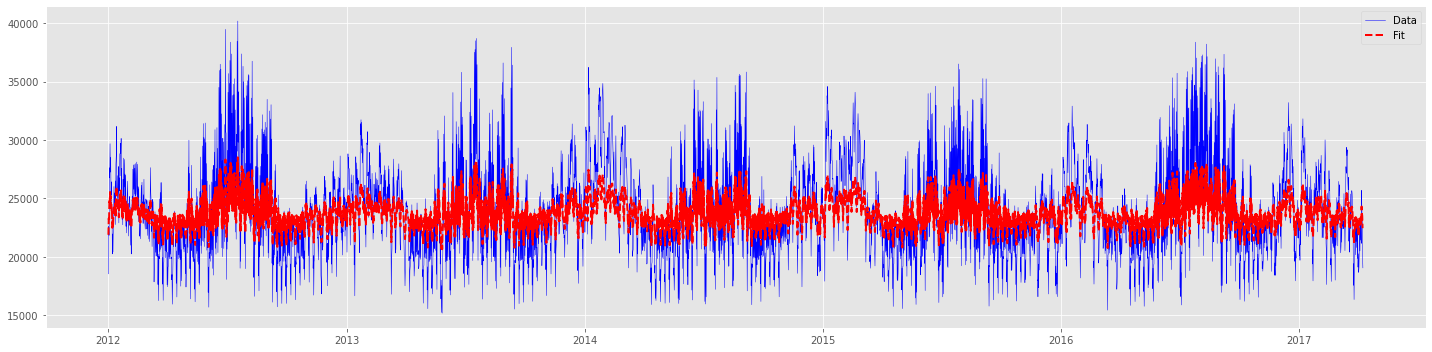

In [109]:
# Compare the training preditiction

plt.figure(figsize = (20, 5))

plt.plot(data[:len(train)], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(trainPred, c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

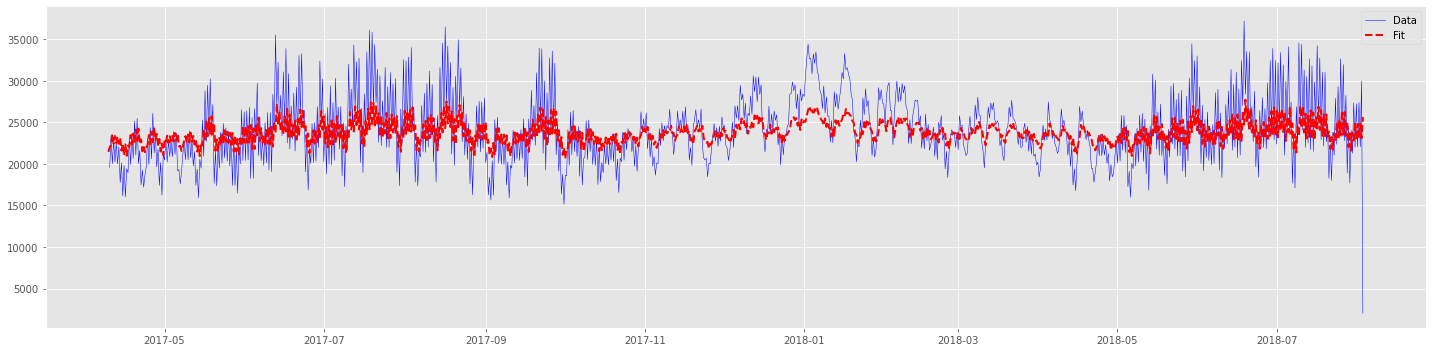

In [100]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(data[-len(test)+2:], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(testPred, c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()